<a href="https://colab.research.google.com/github/joshuajacobs2020/AirbnbPricePrediction/blob/main/Regularization_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/joshuajacobs2020/AirbnbPricePrediction
%cd /content/AirbnbPricePrediction

Cloning into 'AirbnbPricePrediction'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 111 (delta 30), reused 23 (delta 5), pack-reused 0
Receiving objects: 100% (111/111), 87.29 MiB | 12.63 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/AirbnbPricePrediction


In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("Data/ImprovedAirbnbCleaned.csv")

In [3]:
# Define X and Y names - using Bronx and Private Room as base case
Xcols = ['number_of_reviews', 'Brooklyn','Manhattan','Staten Island','Queens', 'longitude','latitude',
        'reviews_per_month', 'calculated_host_listings_count', 'Entire home/apt',
        'Shared room', 'textfeat1', 'textfeat2', 'textfeat3',
       'textfeat4', 'textfeat5', 'textfeat6']
ycols = ["price"]

## Splitting Data

In [4]:
# Splitting Data
from sklearn.model_selection import train_test_split

# Splitting test and training
split_data = train_test_split(df, random_state = 1, test_size = .2)
training = split_data[0]
test = split_data[1]

# Splitting into x and y
y_train = training[ycols]
X_train = training[Xcols]

y_test = test[ycols]
X_test = test[Xcols]

print("Training obs: {}".format(training.shape[0]))
print("Test obs: {}".format(test.shape[0]))

Training obs: 39116
Test obs: 9779


## Ridge Regression

### Cross-validating for best lambda

In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Setting random_state, since I use LOOCV this shouldn't be too important
np.random.RandomState(123)

# Setting tuning parameters to check
lambdas = 10**np.linspace(4, -6, 101)

# Cross Validating for optimal lambda
ridgecv = ElasticNetCV(alphas=lambdas, cv = None, l1_ratio=0.) # perform LOOCV
scaler = StandardScaler(with_mean=True, with_std=True)

# Define pipeline steps to scale and then do cross-validation
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridgecv', ridgecv)]);
pipeCV.fit(X_train, y_train);

# Get optimal lambda
tuned_ridge = pipeCV.named_steps['ridgecv']
tunedlambda_ridge  = tuned_ridge.alpha_

In [6]:
print("Optimal Lambda:", tunedlambda_ridge)

Optimal Lambda: 0.002511886431509577


In [7]:
from sklearn.linear_model import Ridge

# Run ridge regression with optimal lambda values
ridge = Ridge(alpha=tunedlambda_ridge)
pipeRidge = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipeRidge.fit(X_train, y_train)

# Getting training MSE
y_pred = pipeRidge.predict(X_train)
print("Training MSE:", np.sqrt(np.mean((y_pred - np.array(y_train))**2)))

# Getting test MSE
y_pred = pipeRidge.predict(X_test)
print("Test MSE:", np.sqrt(np.mean((y_pred - np.array(y_test))**2)))

Training MSE: 224.8215077549645
Test MSE: 243.15433899625776


### Getting ridge coefficients

In [8]:
import sklearn.linear_model as skl

# Standardizing
scaler = StandardScaler(with_mean=True, with_std=True)
scalerfit = scaler.fit(X_train)
X_train_s = scalerfit.transform(X_train)

# Getting shrinkages
soln_array = skl.ElasticNet.path(X_train_s, y_train,
                                 l1_ratio=1.,
                                 alphas=lambdas)[1]
soln_array.shape

(1, 17, 101)

In [10]:
lambdas[76]

0.0002511886431509577

In [11]:
soln_path = pd.DataFrame(soln_array[0].T, columns=X_test.columns, index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'

beta_hat = soln_path.loc[soln_path.index[76]]
df = pd.DataFrame(beta_hat)
ridgecoefs = pd.DataFrame(beta_hat)
ridgecoefs["ridge"] = ridgecoefs
ridgecoefs  = ridgecoefs[["ridge"]]

## Lasso Regression

In [12]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

# Setting random_state, since I use LOOCV this shouldn't be too important
np.random.RandomState(123)

# Setting tuning parameters to check
lambdas = 10**np.linspace(4, -6, 101)

# Cross Validating for optimal lambda
lassocv = ElasticNetCV(alphas=lambdas, cv = None, l1_ratio=1) # perform LOOCV
scaler = StandardScaler(with_mean=True, with_std=True)

# Define pipeline steps to scale and then do cross-validation
pipeCV = Pipeline(steps=[('scaler', scaler), ('lassocv', lassocv)]);
pipeCV.fit(X_train, np.array(y_train).ravel())

# Get optimal lambda
tuned_lambda = pipeCV.named_steps['lassocv']
tunedlambda_lasso  = tuned_lambda.alpha_

In [13]:
print("Optimal Lasso Alpha:", tunedlambda_lasso)

Optimal Lasso Alpha: 1e-06


In [14]:
from sklearn.linear_model import ElasticNet

# Run lasso regression with optimal lambda values
lasso = ElasticNet(alpha=tunedlambda_lasso, l1_ratio=1.)
pipeLasso = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])
pipeLasso.fit(X_train, y_train)

# Getting training MSE
y_pred = pipeLasso.predict(X_train)
print("Training MSE:", np.sqrt(np.mean((y_pred - np.array(y_train.values).ravel())**2)))

# Getting test MSE
y_pred = pipeLasso.predict(X_test)
print("Test MSE:", np.sqrt(np.mean((y_pred - np.array(y_test.values).ravel())**2)))

Training MSE: 224.82150775496447
Test MSE: 243.15433906163474


### Getting lasso shrinkage graphs + coefs table

In [ ]:
import sklearn.linear_model as skl

# Standardizing
scaler = StandardScaler(with_mean=True, with_std=True)
scalerfit = scaler.fit(X_train)
X_train_s = scalerfit.transform(X_train)

# Getting shrinkages
soln_array = skl.ElasticNet.path(X_train_s, y_train,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape

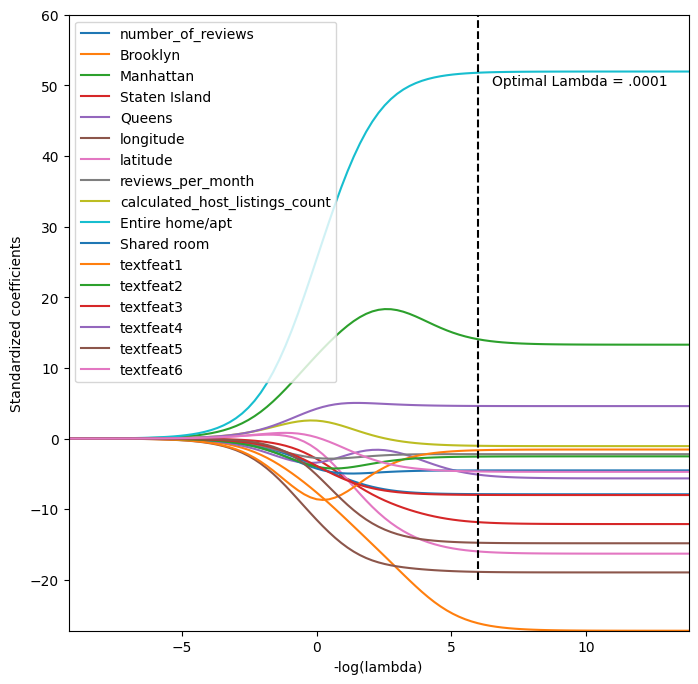

In [19]:
soln_path = pd.DataFrame(soln_array[0].T, columns=X_test.columns, index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'

from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt

# Plot temperature coefficient
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
plt.vlines(x=6,ymin=-20,ymax=60,color="black", linestyle="dashed")
plt.text(6.5,50,"Optimal Lambda = .0001")
ax.set_xlabel('-log(lambda)', fontsize=10)
ax.set_ylabel('Standardized coefficients', fontsize=10)
ax.margins(0)
ax.legend(loc='upper left');

In [28]:
beta_hat = soln_path.loc[soln_path.index[66]]
df = pd.DataFrame(beta_hat)
df["lasso"] = df
LassoCoefs = df[["lasso"]]

# Combining Coefficients

In [29]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Standardizing
X_train_s = X_train[Xcols]
scaler = StandardScaler(with_mean=True, with_std=True)
scalerfit = scaler.fit(X_train_s)
X_train_s = scalerfit.transform(X_train_s)
X_test_s = scalerfit.transform(X_test)

# Add constant to X matrix
Xconst = sm.add_constant(X_train_s)

# Fit a linear regression model
model = sm.OLS(y_train,Xconst)
results = model.fit()
OLScoefs = pd.DataFrame(results.params[1:],columns=["OLS"])
OLScoefs.index = Xcols

# Combine coefficients and make a table
combined_coefs = pd.concat([OLScoefs,ridgecoefs,LassoCoefs],axis=1)

from tabulate import tabulate
print(tabulate(combined_coefs, headers=["Variable","OLS","Ridge","Lasso"],  floatfmt=".2f", tablefmt='latex'))

\begin{tabular}{lrrr}
\hline
 Variable                       &    OLS &   Ridge &   Lasso \\
\hline
 number\_of\_reviews              &  -7.88 &   -7.88 &   -7.86 \\
 Brooklyn                       & -27.20 &  -27.20 &  -26.13 \\
 Manhattan                      &  13.29 &   13.29 &   14.07 \\
 Staten Island                  & -12.10 &  -12.10 &  -11.83 \\
 Queens                         &  -5.64 &   -5.64 &   -5.10 \\
 longitude                      & -18.95 &  -18.95 &  -18.87 \\
 latitude                       & -16.29 &  -16.29 &  -15.98 \\
 reviews\_per\_month              &  -2.21 &   -2.21 &   -2.21 \\
 calculated\_host\_listings\_count &  -1.07 &   -1.07 &   -1.02 \\
 Entire home/apt                &  51.96 &   51.96 &   51.79 \\
 Shared room                    &  -4.51 &   -4.51 &   -4.51 \\
 textfeat1                      &  -1.55 &   -1.55 &   -1.65 \\
 textfeat2                      &  -2.52 &   -2.52 &   -2.55 \\
 textfeat3                      &  -8.00 &   -8.00 &   -7.98 